In [2]:
import json
from tqdm import tqdm
from pathlib import Path
import sys
import csv
import os
from collections import defaultdict, Counter
import ast
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import shutil
import ast
import base64
import numpy as np
import torch
from functools import lru_cache 

_ = csv.field_size_limit(sys.maxsize)

In [ ]:
with open('/home/eugene/anaconda3/envs/frcnn/lib/python3.7/site-packages/data/personality_captions/test.json') as f:
    orig_gt = {x['image_hash'] : x for x in json.load(f)}

with open('../datasets/personality_captions/test.json') as f:
    gt = {x['image_hash'] : x for x in json.load(f)}

with open('../experiments/sequence/pred.personality_captions.test.beam5.max20.odlabels_coco_format.json') as f:
    sequence = json.load(f)
    
with open('../experiments/inject/checkpoint-20-15000/pred.personality_captions.test.beam5.max20.odlabels_coco_format.json') as f:
    inject = json.load(f)

In [ ]:
for i in range(20):
    shutil.copy(f'../datasets/yfcc_images/{inject[i]["image_id"]}.jpg', f'../datasets/yfcc_extract/{inject[i]["image_id"]}.jpg')

In [ ]:
with open('../datasets/personality_captions/test.label.tsv') as f:
    reader = csv.reader(f, delimiter='\t')
    labels = {}
    for x in tqdm(reader):
        eval_list = ast.literal_eval(x[1])
        all_labels = [l['class'] for l in eval_list]
        labels[x[0]] = all_labels

In [ ]:
def difference(i):
    image_id, seq_caption = sequence[i].values()
    _, inj_caption = inject[i].values()
    
    actual_caption = gt[image_id]['comment']
    personality = gt[image_id]['personality']
    orig = orig_gt[image_id]['personality']
    assert actual_caption == orig_gt[image_id]['comment']
    
    img = mpimg.imread(f'../datasets/yfcc_images/{image_id}.jpg')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print(f"ID: {image_id}, Personality: {personality} \
    \n\nLabels : {labels[image_id]}\
    \n\nGround Truth: {actual_caption} \
    \nSequence: {seq_caption} \
    \nInject: {inj_caption}")

In [ ]:
for i in range(20):
    difference(i)

## Captions

- most images tied to only one personality and contain one caption only

In [ ]:
personalities = defaultdict(list)
for ftype in ['train', 'val', 'test']:
    with open(f'../datasets/personality_captions/{ftype}.json') as f:
        for x in json.load(f):
            personalities[x['personality']].append(x['comment'])

In [ ]:
personalities['Neurotic']

In [ ]:
with open('/home/eugene/anaconda3/envs/frcnn/lib/python3.7/site-packages/data/personality_captions/test.json') as f:
    orig_gt = {x['image_hash'] : x for x in json.load(f)}

In [ ]:
orig_gt['73a33823bb3e8ef618bf52f4b3147d'].keys()

### check if parlai uses caption retrieval

In [ ]:
all_captions = set()
for v in personalities.values():
    all_captions.update(v)

In [ ]:
generated = "summer camp is so much fun!"
generated in all_captions

# Confirm features loaded correctly

In [22]:
with open('../datasets/personality_captions/val.json') as f:
    gt = {x['image_hash'] : x for x in json.load(f)}
len(gt)

4989

In [23]:
with open('../datasets/personality_captions/val.label.tsv') as f:
    reader = csv.reader(f, delimiter='\t')
    labels = {}
    for x in tqdm(reader):
        eval_list = ast.literal_eval(x[1])
        all_labels = [l['class'] for l in eval_list]
        labels[x[0]] = all_labels

assert all(x in labels for x in gt.keys())

4989it [00:02, 2283.35it/s]


In [37]:
image_hash = 'd0abfaaa84faa3729e2a76b838a317'

print(gt[image_hash])
print(labels[image_hash])
print(len(labels[image_hash]))

{'personality': 'Irrational', 'comment': 'Is she doing a backflip twist?', 'image_hash': 'd0abfaaa84faa3729e2a76b838a317'}
['grass', 'park', 'grass', 'shirt', 'sky', 'sky', 'shirt', 'flag', 'shorts', 'man', 'shoe', 'man', 'woman', 'grass', 'woman', 'shoe', 'woman', 'man', 'tree', 'man', 'hair', 'shorts', 'people', 'head', 'shoe', 'flag', 'hair', 'hair', 'trees', 'head', 'face', 'man', 'woman', 'shirt', 'shorts', 'pants', 'hair', 'hand', 'shoes', 'shirt', 'shirt', 'shoes']
42


In [33]:
idx = 690

with open('../datasets/personality_captions/val.feature.lineidx') as f:
    lineidx = [int(i.strip()) for i in f.readlines()]

with open('../datasets/personality_captions/val.feature.tsv') as f:
    f.seek(lineidx[idx])
    x = f.readline().split('\t')
    feat_info = ast.literal_eval(x[1])
    num_boxes = feat_info['num_boxes']
    features = np.frombuffer(base64.b64decode(feat_info['features']), np.float32).reshape((num_boxes, -1))

In [34]:
features

array([[0.        , 0.7432358 , 0.        , ..., 0.99833333, 0.78539836,
        0.48384783],
       [0.00362616, 1.5246546 , 0.        , ..., 0.88631034, 0.88410103,
        0.6500872 ],
       [0.        , 0.6016352 , 0.        , ..., 0.9552578 , 0.8438208 ,
        0.58567244],
       ...,
       [2.1922884 , 0.00713   , 0.        , ..., 0.38407785, 0.13397083,
        0.15796061],
       [0.77029437, 0.        , 0.        , ..., 0.42675507, 0.08198227,
        0.1558083 ],
       [0.00369582, 3.601428  , 0.521975  , ..., 0.8618137 , 0.21393006,
        0.11427486]], dtype=float32)

In [35]:
torch.sum(torch.tensor(features))

tensor(54348.6758)

In [36]:
num_boxes

42

# compare to ensure correct generation

In [ ]:
@lru_cache(maxsize=128)
def get_labels(old):
    # compare labels
    with open(old) as f:
        reader = csv.reader(f, delimiter='\t')
        od_labels = {}
        for x in tqdm(reader):
            eval_list = ast.literal_eval(x[1])
            all_labels = [l['class'] for l in eval_list]
            od_labels[x[0]] = all_labels
    return od_labels


In [ ]:
def compare_labels(old, new):
    od_labels = get_labels(old)
    with open(new) as f:
        reader = csv.reader(f, delimiter='\t')
        for x in tqdm(reader):
            if x[0] in od_labels:
                eval_list = ast.literal_eval(x[1])
                all_labels = [l['class'] for l in eval_list]
                assert_that(all_labels).is_equal_to(od_labels[x[0]])
            else:
                tqdm.write(x[0])

In [ ]:
# compare features
@lru_cache(maxsize=128)
def get_features(old):
    with open(old) as f:
        reader = csv.reader(f, delimiter='\t')
        gen = {}
        for x in tqdm(reader):
            feat_info = ast.literal_eval(x[1])
            num_boxes = feat_info['num_boxes']
            features = np.frombuffer(base64.b64decode(feat_info['features']), np.float32).reshape((num_boxes, -1))
            gen[x[0]] = (features, num_boxes)
    return gen

In [ ]:
def compare_features(old, new):
    gen = get_features(old)
    with open(new) as f:
        reader = csv.reader(f, delimiter='\t')
        for x in tqdm(reader):
            if x[0] in gen:
                feat_info = ast.literal_eval(x[1])
                num_boxes = feat_info['num_boxes']
                features = np.frombuffer(base64.b64decode(feat_info['features']), np.float32).reshape((num_boxes, -1))
                
                assert_that(num_boxes).is_equal_to(gen[x[0]][1])
                (features == gen[x[0]][0]).all()
            else:
                print(x[0])

# compare regenerated test images for pic

In [ ]:
compare_labels('../datasets/personality_captions/test.label.tsv', '../datasets/regen/personality_captions/labels.yfcc.tsv.0')
    

In [ ]:
compare_features('../datasets/personality_captions/test.feature.tsv', '../datasets/regen/personality_captions/yfcc.tsv.0')

# compare coco_captions

In [ ]:
# compare labels
with open("../datasets/coco_caption/test.label.tsv") as f:
    reader = csv.reader(f, delimiter='\t')
    od_labels = {}
    for x in tqdm(reader):
        eval_list = ast.literal_eval(x[1])
        all_labels = [l for l in eval_list]
        od_labels[x[0]] = all_labels

with open('../datasets/regen/coco_caption/labels.yfcc.tsv.0') as f:
    reader = csv.reader(f, delimiter='\t')
    new_labels = {}
    for x in tqdm(reader):
        eval_list = ast.literal_eval(x[1])
        all_labels = [l for l in eval_list]
        new_labels[x[0]] = all_labels

In [ ]:
features = get_features('../datasets/coco_caption/test.feature.tsv')

with open('../datasets/regen/coco_caption/yfcc.tsv.0') as f:
    reader = csv.reader(f, delimiter='\t')
    new_features = {}
    for x in tqdm(reader):
        feat_info = ast.literal_eval(x[1])
        num_boxes = feat_info['num_boxes']
        np_arr = np.frombuffer(base64.b64decode(feat_info['features']), np.float32).reshape((num_boxes, -1))
        new_features[x[0]] = (np_arr, num_boxes)

In [ ]:
new_labels.keys()

In [ ]:
# compare 
image_id = '483108'

a = new_features[image_id][0]
b = features[image_id][0]
b = np.delete(b, (27), axis=0)
x = abs(a-b) / (b+ np.finfo(float).eps)
x = np.mean(x, 1)
x = np.mean(x)
x * 100

In [ ]:
def get_diff(i):
    a = np.asarray(new_labels[image_id][i]['rect'])
    b = np.asarray(od_labels[image_id][i]['rect'])
    x = abs(a-b) / (b+ np.finfo(float).eps)
    x = np.mean(x)
    return x
    
np.mean([get_diff(i) for i in range(37)])

# check labels loss of information

In [6]:
captions = {}
labels = {}

for name in ['train', 'test', 'val']:
    with open(f'../datasets/personality_captions/{name}.json') as f:
        for x in json.load(f):
            captions[x['image_hash']] = x
            
    with open(f"../datasets/personality_captions/{name}.label.tsv") as f:
        reader = csv.reader(f, delimiter='\t')
        for x in tqdm(reader):
            eval_list = ast.literal_eval(x[1])
            labels[x[0]] = [l['class'] for l in eval_list]

186234it [01:41, 1842.56it/s]
9977it [00:05, 1879.03it/s]
4989it [00:02, 2086.24it/s]


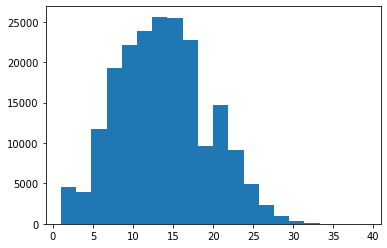

In [14]:
diff = []

for k, v in labels.items():
    diff.append(len(set(v)))

plt.hist(diff, bins=20)
plt.show()

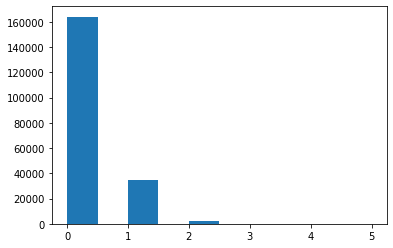

In [20]:
included = []

for k, v in labels.items():
    
    caption = set(captions[k]['comment'].split(' '))
    found = caption.intersection(set(v))
        
    included.append(len(found))
    

plt.hist(included)
plt.show()